<a href="https://www.kaggle.com/code/yorkyong/aspect-based-sentiment-analysis-llama-ft?scriptVersionId=202299148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [5]:
#with reference from https://www.kaggle.com/code/lucamassaron/fine-tune-llama-2-for-sentiment-analysis

In [6]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import re
import os
from tqdm import tqdm
import bitsandbytes as bnb
from collections import defaultdict
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [10]:
pd.set_option('display.max_colwidth', None)  # Show full width of each column

In [11]:
print(f"pytorch version {torch.__version__}")

pytorch version 2.4.0


In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"working on {device}")

working on cuda:0


# Preparing the data and the core evaluation functions

In [13]:
filename1= '/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/cleaned_data_ABSA_col.xlsx'
filename2= "/kaggle/input/mcdonalds-review-dataset-6-months-clean-sentiment/cleaned_data_additional.csv"

In [14]:
df = pd.read_excel(filename1)
df_add = pd.read_csv(filename2,encoding="utf8", encoding_errors="replace")

In [15]:
df.head()

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,Food,Service,Cleanliness,Price,Others
0,"1044 US-11, Champlain, NY 12919, United States",12919,11931,6 months ago,negative,Food seems to be getting worse. Tables dirty. Sketchy crowd loitering within the store.,food seems getting worse table dirty sketchy crowd loitering within store,1,0,1,0,1
1,"1044 US-11, Champlain, NY 12919, United States",12919,11895,a week ago,negative,Food was slow. Manager (short hair woman) was having a mental breakdown or something and was being rude. She needs to be fired. Her name was Elizabeth or something. Very unprofessional.,food slow manager short hair woman mental breakdown something rude need fired name elizabeth something unprofessional,1,1,0,0,1
2,"1044 US-11, Champlain, NY 12919, United States",12919,11920,a month ago,negative,Franchise owners need to hire more staff to keep up with demand,franchise owner need hire staff keep demand,0,1,0,0,1
3,"1044 US-11, Champlain, NY 12919, United States",12919,11912,2 weeks ago,negative,Haven't seen a McDonald's so lost in my life :(,seen lost life,0,0,0,0,1
4,"1044 US-11, Champlain, NY 12919, United States",12919,11897,4 months ago,negative,"I came there to pick up order around 5 in the morning, there was a manager(brown hair) who dealt with me very rudely, i politely requested for my uber pick up but he showed me attitude and just shut the window. That was an awful experience for me and i would like to suggest them to show some etiquettes and respect towards their customers. I also work in a restaurant and know how to deal with the customers and uber orders.",came pick order around morning managerbrown hair dealt rudely politely requested uber pick showed attitude shut window awful experience would like suggest show etiquette respect towards customer also work restaurant know deal customer uber order,0,1,0,0,1


In [16]:
df_add.head()

,Unnamed: 0,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,service,cleanliness,food,price,others
0,27,"621 Broadway, Newark, NJ 07104, United States",7104,306,9 months ago,neutral,"Prices were as expected for fast food, no surprises.",price expected fast surprise,0,0,0,2,0
1,63,"621 Broadway, Newark, NJ 07104, United States",7104,851,9 months ago,neutral,The self-service drink station was functioning,selfservice drink station functioning,0,2,0,0,0
2,99,"621 Broadway, Newark, NJ 07104, United States",7104,1663,9 months ago,neutral,The main counter had a laminate surface,main counter laminate surface,0,2,0,0,0
3,135,"621 Broadway, Newark, NJ 07104, United States",7104,1978,8 months ago,neutral,The cashier asked if the customer wanted to add any items to their order,cashier asked customer wanted add item,2,0,0,0,0
4,171,"621 Broadway, Newark, NJ 07104, United States",7104,2759,8 months ago,neutral,Sundaes were topped with chocolate or caramel sauce,sundae topped chocolate caramel sauce,0,0,2,0,0


# Combine df and df_add

In [17]:
# Drop the 'Unnamed: 0' column from df_add
df_add = df_add.drop(columns=['Unnamed: 0'])

# Standardize column names in df_add to match df
df_add = df_add.rename(columns={
    'service': 'Service',
    'cleanliness': 'Cleanliness',
    'food': 'Food',
    'price': 'Price',
    'others': 'Others'
})

# Use pd.concat to append df_add to df
df_combined = pd.concat([df, df_add], ignore_index=True)

df_combined

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,Food,Service,Cleanliness,Price,Others
0,"1044 US-11, Champlain, NY 12919, United States",12919,11931,6 months ago,negative,Food seems to be getting worse. Tables dirty. Sketchy crowd loitering within the store.,food seems getting worse table dirty sketchy crowd loitering within store,1,0,1,0,1
1,"1044 US-11, Champlain, NY 12919, United States",12919,11895,a week ago,negative,Food was slow. Manager (short hair woman) was having a mental breakdown or something and was being rude. She needs to be fired. Her name was Elizabeth or something. Very unprofessional.,food slow manager short hair woman mental breakdown something rude need fired name elizabeth something unprofessional,1,1,0,0,1
2,"1044 US-11, Champlain, NY 12919, United States",12919,11920,a month ago,negative,Franchise owners need to hire more staff to keep up with demand,franchise owner need hire staff keep demand,0,1,0,0,1
3,"1044 US-11, Champlain, NY 12919, United States",12919,11912,2 weeks ago,negative,Haven't seen a McDonald's so lost in my life :(,seen lost life,0,0,0,0,1
4,"1044 US-11, Champlain, NY 12919, United States",12919,11897,4 months ago,negative,"I came there to pick up order around 5 in the morning, there was a manager(brown hair) who dealt with me very rudely, i politely requested for my uber pick up but he showed me attitude and just shut the window. That was an awful experience for me and i would like to suggest them to show some etiquettes and respect towards their customers. I also work in a restaurant and know how to deal with the customers and uber orders.",came pick order around morning managerbrown hair dealt rudely politely requested uber pick showed attitude shut window awful experience would like suggest show etiquette respect towards customer also work restaurant know deal customer uber order,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2777,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1627,10 months ago,neutral,Electrical outlets were present on some walls,electrical outlet present wall,0,0,2,0,0
2778,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1946,11 months ago,neutral,Customers used the self-service kiosks to place orders,customer used selfservice kiosk place order,0,2,0,0,0
2779,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,2560,10 months ago,neutral,The Double Cheeseburger had two beef patties and two slices of cheese,double cheeseburger two beef patty two slice cheese,2,0,0,0,0
2780,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,3091,10 months ago,neutral,The restaurant offered free Wi-Fi to customers,restaurant offered free wifi customer,0,0,0,0,2


# Replace 0: Missing as 2: Neutral

In [18]:
# List of aspect columns
aspect_columns = ['Food', 'Service', 'Cleanliness', 'Price', 'Others']

# Replace 0 with 2 in the aspect columns
df_combined[aspect_columns] = df_combined[aspect_columns].replace(0, 2)

# Display the updated dataframe
df_combined

,store_address,location,reviewer_id,review_time,actual_sentiment,review,token_review_clean,Food,Service,Cleanliness,Price,Others
0,"1044 US-11, Champlain, NY 12919, United States",12919,11931,6 months ago,negative,Food seems to be getting worse. Tables dirty. Sketchy crowd loitering within the store.,food seems getting worse table dirty sketchy crowd loitering within store,1,2,1,2,1
1,"1044 US-11, Champlain, NY 12919, United States",12919,11895,a week ago,negative,Food was slow. Manager (short hair woman) was having a mental breakdown or something and was being rude. She needs to be fired. Her name was Elizabeth or something. Very unprofessional.,food slow manager short hair woman mental breakdown something rude need fired name elizabeth something unprofessional,1,1,2,2,1
2,"1044 US-11, Champlain, NY 12919, United States",12919,11920,a month ago,negative,Franchise owners need to hire more staff to keep up with demand,franchise owner need hire staff keep demand,2,1,2,2,1
3,"1044 US-11, Champlain, NY 12919, United States",12919,11912,2 weeks ago,negative,Haven't seen a McDonald's so lost in my life :(,seen lost life,2,2,2,2,1
4,"1044 US-11, Champlain, NY 12919, United States",12919,11897,4 months ago,negative,"I came there to pick up order around 5 in the morning, there was a manager(brown hair) who dealt with me very rudely, i politely requested for my uber pick up but he showed me attitude and just shut the window. That was an awful experience for me and i would like to suggest them to show some etiquettes and respect towards their customers. I also work in a restaurant and know how to deal with the customers and uber orders.",came pick order around morning managerbrown hair dealt rudely politely requested uber pick showed attitude shut window awful experience would like suggest show etiquette respect towards customer also work restaurant know deal customer uber order,2,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2777,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1627,10 months ago,neutral,Electrical outlets were present on some walls,electrical outlet present wall,2,2,2,2,2
2778,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,1946,11 months ago,neutral,Customers used the self-service kiosks to place orders,customer used selfservice kiosk place order,2,2,2,2,2
2779,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,2560,10 months ago,neutral,The Double Cheeseburger had two beef patties and two slices of cheese,double cheeseburger two beef patty two slice cheese,2,2,2,2,2
2780,"550 Lawrence Expy, Sunnyvale, CA 94086, United States",94086,3091,10 months ago,neutral,The restaurant offered free Wi-Fi to customers,restaurant offered free wifi customer,2,2,2,2,2


In [19]:
df = df_combined

# Train Test Split with Stratification by Actual Sentiment

In [20]:
X_train = []
X_test = []
X_eval = []

# Iterate through the unique sentiments to split data into train, test, and eval
for sentiment in ["positive", "neutral", "negative"]:
    # Split into train and test
    train, test = train_test_split(
        df[df.actual_sentiment == sentiment], test_size=0.3, random_state=42
    )
    
    # Split remaining data for evaluation
    test, eval_split = train_test_split(test, test_size=0.5, random_state=42)
    
    # Append to respective lists
    X_train.append(train)
    X_test.append(test)
    X_eval.append(eval_split)

# Concatenate the results
X_train = pd.concat(X_train).reset_index(drop=True)
X_test = pd.concat(X_test).reset_index(drop=True)
X_eval = pd.concat(X_eval).reset_index(drop=True)

In [21]:
print(f"The train set for modelling has {len(X_train)} rows.")
print(f"The test set for modelling has {len(X_test)} rows.")
print(f"The eval set for modelling has {len(X_eval)} rows.")

The train set for modelling has 1946 rows.
The test set for modelling has 417 rows.
The eval set for modelling has 419 rows.


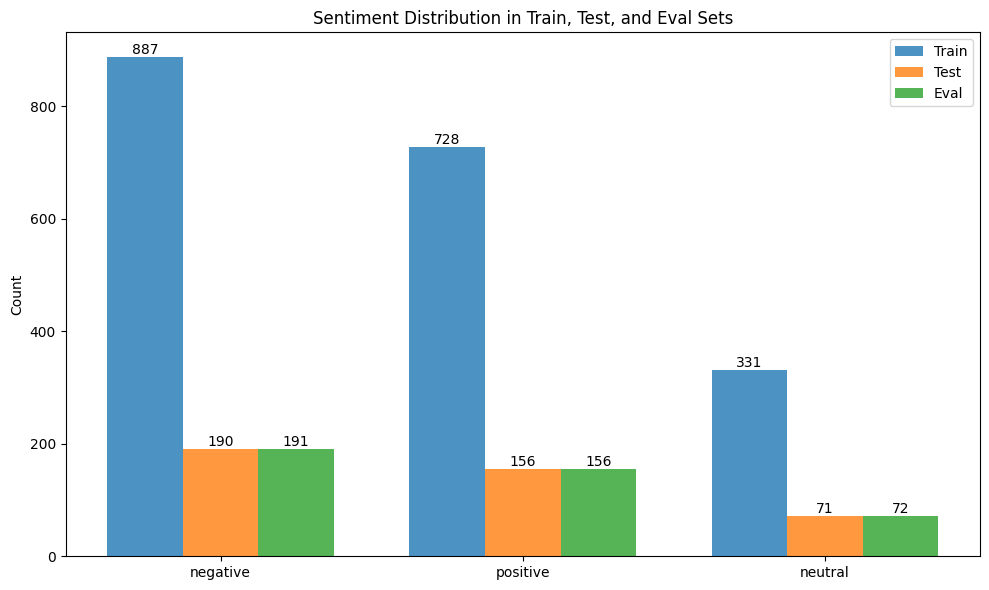

In [22]:
import matplotlib.pyplot as plt

def plot_sentiment_distribution(X_train, X_test, X_eval):
    # Count sentiments in train, test, and eval sets
    train_counts = X_train['actual_sentiment'].value_counts()
    test_counts = X_test['actual_sentiment'].value_counts()
    eval_counts = X_eval['actual_sentiment'].value_counts()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot bars
    x = range(len(train_counts))
    width = 0.25  # Adjust width for three groups
    ax.bar([i - width for i in x], train_counts.values, width, label='Train', alpha=0.8)
    ax.bar([i for i in x], test_counts.values, width, label='Test', alpha=0.8)
    ax.bar([i + width for i in x], eval_counts.values, width, label='Eval', alpha=0.8)

    # Customize the plot
    ax.set_ylabel('Count')
    ax.set_title('Sentiment Distribution in Train, Test, and Eval Sets')
    ax.set_xticks(x)
    ax.set_xticklabels(train_counts.index)
    ax.legend()

    # Add value labels on top of each bar for Train, Test, and Eval
    for i, v in enumerate(train_counts.values):
        ax.text(i - width, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(test_counts.values):
        ax.text(i, v, str(v), ha='center', va='bottom')
    for i, v in enumerate(eval_counts.values):
        ax.text(i + width, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_sentiment_distribution(X_train, X_test, X_eval)

# Prompt

In [23]:
def generate_prompt(row):
    aspects = ["Food", "Service", "Cleanliness", "Price", "Others"]
    scores = {aspect: row[aspect] for aspect in aspects}
    
    return f"""
Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.
For each aspect, assign a sentiment score based on the following scale:
1: Negative sentiment
2: Neutral or the aspect is not explicitly mentioned or does not exist in the review
3: Positive sentiment
IMPORTANT:
- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.
- If an aspect is not mentioned or can only be inferred as neutral or non-existent, assign it a score of 2.
- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.
- Provide ONLY the scores in the exact format shown below, with no additional text or explanations.
Provide your analysis in the following format ONLY:
Food=[score]
Service=[score]
Cleanliness=[score]
Price=[score]
Others=[score]
Review: {row['review']}
Analysis:
Food={scores['Food']}
Service={scores['Service']}
Cleanliness={scores['Cleanliness']}
Price={scores['Price']}
Others={scores['Others']}
""".strip()


def generate_test_prompt(row):
    return f"""
Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.
For each aspect, assign a sentiment score based on the following scale:
1: Negative sentiment
2: Neutral or the aspect is not explicitly mentioned or does not exist in the review
3: Positive sentiment
IMPORTANT:
- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.
- If an aspect is not mentioned or inferred to be neutral or non-existent, assign it a score of 2.
- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.
- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.
- Do not continue with unrelated reviews or add any content beyond the requested format.
- Interpret the review accurately, considering both explicit mentions and strong implications.
Provide your analysis in the following format ONLY:
Food=X Service=X Cleanliness=X Price=X Others=X
Where X is the score (1, 2, or 3) for each aspect.
Review: {row['review']}
Analysis:
""".strip()


In [24]:
# Generate the full prompt (input) for training and evaluation data
X_train['prompt'] = X_train.apply(generate_prompt, axis=1)
X_eval['prompt'] = X_eval.apply(generate_prompt, axis=1)

# Select the necessary columns for training and evaluation
X_train = X_train[['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others']]
X_eval = X_eval[['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others']]

# Prepare the true labels for evaluation
y_true = X_test[['Food', 'Service', 'Cleanliness', 'Price', 'Others']]

# For X_test, generate the test prompt without sentiment scores
X_test['prompt'] = X_test.apply(generate_test_prompt, axis=1)
X_test = X_test[['review', 'prompt']]

# Convert the DataFrames to datasets
train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)
test_data = Dataset.from_pandas(X_test)

In [25]:
train_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 1946
})

In [26]:
eval_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 419
})

In [27]:
X_test

,review,prompt
0,Wonderful staff. Very accommodating. Food was made quick and well,"Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n1: Negative sentiment\n2: Neutral or the aspect is not explicitly mentioned or does not exist in the review\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or inferred to be neutral or non-existent, assign it a score of 2.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (1, 2, or 3) for each aspect.\nReview: Wonderful staff. Very accommodating. Food was made quick and well\nAnalysis:"
1,Yum,"Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n1: Negative sentiment\n2: Neutral or the aspect is not explicitly mentioned or does not exist in the review\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or inferred to be neutral or non-existent, assign it a score of 2.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (1, 2, or 3) for each aspect.\nReview: Yum\nAnalysis:"
2,"Very busy site, a clean as it could be,","Analyze the sentiment of the following review for five specific aspects: Food, Service, Cleanliness, Price, and Others.\nFor each aspect, assign a sentiment score based on the following scale:\n1: Negative sentiment\n2: Neutral or the aspect is not explicitly mentioned or does not exist in the review\n3: Positive sentiment\nIMPORTANT:\n- Only provide scores for aspects that are EXPLICITLY mentioned or can be DIRECTLY inferred from the review.\n- If an aspect is not mentioned or inferred to be neutral or non-existent, assign it a score of 2.\n- Use the 'Others' category to capture any significant aspects or overall sentiment not covered by the other categories.\n- Provide ONLY the scores in the exact format shown below, with no additional text, explanations, or notes.\n- Do not continue with unrelated reviews or add any content beyond the requested format.\n- Interpret the review accurately, considering both explicit mentions and strong implications.\nProvide your analysis in the following format ONLY:\nFood=X Service=X Cleanliness=X Price=X Others=X\nWhere X is the score (1, 2, or 3) for each aspect.\nReview: Very busy site, a clean as it could be,\nAnalysis:"
3,I came right at closing time and the manager took my order then when I got to the first window I was told sorry we are closed. I told him someone repeated my order and went to ask at the same time the manager came to the first window after telling his coworker the situation the manager hurry and got payment then hurried back to round

# Create Evaluation Function

In [28]:
def evaluate(y_true, y_pred):
    aspects = ['Food', 'Service', 'Cleanliness', 'Price', 'Others']
    
    overall_accuracy = 0
    summary = {}
    
    for aspect in aspects:
        y_true_scores = y_true[aspect].tolist()
        y_pred_scores = y_pred[aspect].tolist()
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true_scores, y_pred_scores)
        overall_accuracy += accuracy
        
        # Generate classification report
        class_report = classification_report(y_true_scores, y_pred_scores, 
                                             labels=[1, 2, 3],  # 1: Negative, 2: Neutral, 3: Positive
                                             target_names=['Negative', 'Neutral', 'Positive'],
                                             zero_division=0)
        
        # Generate confusion matrix
        conf_matrix = confusion_matrix(y_true_scores, y_pred_scores, labels=[1, 2, 3])
        
        # Print results
        print(f"\nEvaluation for {aspect.capitalize()}:")
#         print("Sample data (first 10 pairs):")
#         for i in range(min(10, len(y_true_scores))):
#             print(f"  True: {y_true_scores[i]}, Pred: {y_pred_scores[i]}")
        
#         print(f"\nAccuracy: {accuracy:.3f}")
        
        print("\nClassification Report:")
        print(class_report)
        
        print("Confusion Matrix:")
        print(conf_matrix)
        print("-----------------------------------------------------------")
        
        # Store summary for this aspect
        summary[aspect] = {
            'accuracy': accuracy,
            'classification_report': class_report,
            'confusion_matrix': conf_matrix.tolist()
        }
    
    overall_accuracy = overall_accuracy / len(aspects)
    print(f"\nOverall Accuracy: {overall_accuracy:.3f}")
    summary['overall_accuracy'] = overall_accuracy
    
    return summary


# Testing model without fine-tuning

In [ ]:
# # For clearing GPU memory
# import gc

# del [
#     model, 
#     tokenizer, 
# ]
# # del [df, X_train, X_eval]

In [ ]:
# for _ in range(100):
#     torch.cuda.empty_cache()
#     gc.collect()

In [29]:
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
# model_name = "/kaggle/input/llama-3.2/transformers/3b-instruct/1"
# model_name = "/kaggle/input/llama-3.1/transformers/405b-instruct/1"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, 
    bnb_4bit_quant_type="nf4", 
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map=device,
    torch_dtype=compute_dtype,
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
print(len(tokenizer))  # Check vocabulary size

128258


In [31]:
def predict(df_data, model, tokenizer, debug=False):
    aspects = ['Food', 'Service', 'Cleanliness', 'Price', 'Others']
    y_pred = []
    
    for i in tqdm(range(len(df_data))):
        row = df_data.iloc[i]
        prompt = row['prompt']
        review = row['review']
        
        # Initialize the text-generation pipeline
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=20,
                        temperature=0.1)
        try:
            result = pipe(prompt)
            generated_text = result[0]['generated_text']
            
            # Extract only the part that matches our expected format
            answer = re.search(r'Analysis:[\s\S]*', generated_text)
            if answer:
                answer = answer.group(0)
            else:
                raise ValueError("Unexpected output format")
            
            # Initialize a dictionary to store scores for all aspects
            scores = {aspect: 2 for aspect in aspects}  # Default is 2 (neutral or not mentioned)
            
            # Extract scores for all aspects
            for aspect in aspects:
                # Match both =X and =[X] formats
                match = re.search(rf'{aspect}=(\[?)(\d)(\]?)', answer, re.IGNORECASE)
                if match:
                    score = int(match.group(2))
                    if 1 <= score <= 3:  # Accept only scores in the range of 1 to 3
                        scores[aspect] = score
            
            y_pred.append(scores)
            
            if debug:
                print(f"\nItem {i}:")
                print(f"Review: {review}")
                print(f"Generated: {answer.strip()}")
                print(f"Parsed sentiments: {scores}")
        
        except Exception as e:
            print(f"Error processing item {i}: {str(e)}")
            # In case of an error, assign all aspects as neutral (2)
            y_pred.append({aspect: 2 for aspect in aspects})
    
    # Convert the list of dictionaries to a DataFrame
    df_pred = pd.DataFrame(y_pred)
    
    return df_pred


In [50]:
y_pred = predict(X_test, model, tokenizer, debug=False)

100%|██████████| 417/417 [16:48<00:00,  2.42s/it]


In [51]:
evaluate(y_true, y_pred)


Evaluation for Food:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.55      0.76      0.64        42
     Neutral       0.94      0.72      0.82       320
    Positive       0.44      0.91      0.60        55

    accuracy                           0.75       417
   macro avg       0.64      0.80      0.68       417
weighted avg       0.83      0.75      0.77       417

Confusion Matrix:
[[ 32  10   0]
 [ 26 231  63]
 [  0   5  50]]
-----------------------------------------------------------

Evaluation for Service:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.85      0.86       136
     Neutral       0.86      0.71      0.78       218
    Positive       0.54      0.87      0.67        63

    accuracy                           0.78       417
   macro avg       0.75      0.81      0.77       417
weighted avg       0.81      0.78      0.79       417

Confusion Matrix:
[

{'Food': {'accuracy': 0.750599520383693,
  'classification_report': '              precision    recall  f1-score   support\n\n    Negative       0.55      0.76      0.64        42\n     Neutral       0.94      0.72      0.82       320\n    Positive       0.44      0.91      0.60        55\n\n    accuracy                           0.75       417\n   macro avg       0.64      0.80      0.68       417\nweighted avg       0.83      0.75      0.77       417\n',
  'confusion_matrix': [[32, 10, 0], [26, 231, 63], [0, 5, 50]]},
 'Service': {'accuracy': 0.7817745803357314,
  'classification_report': '              precision    recall  f1-score   support\n\n    Negative       0.87      0.85      0.86       136\n     Neutral       0.86      0.71      0.78       218\n    Positive       0.54      0.87      0.67        63\n\n    accuracy                           0.78       417\n   macro avg       0.75      0.81      0.77       417\nweighted avg       0.81      0.78      0.79       417\n',
  'confus

# FineTuning

In [32]:
eval_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 419
})

In [33]:
train_data

Dataset({
    features: ['review', 'prompt', 'Food', 'Service', 'Cleanliness', 'Price', 'Others'],
    num_rows: 1946
})

In [34]:
output_dir="trained_weigths"
peft_config = LoraConfig(
        lora_alpha=16, 
        lora_dropout=0.1,
        r=64,
        bias="none",
        target_modules=["q_proj", "v_proj"],  # Specify exact linear layers (adjust based on model architecture)
        task_type="CAUSAL_LM",
        use_dora=True
)
training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=16,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,                         # log every 10 steps
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=-1,                             # max step as -1 to use all epochs
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=True,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
#     report_to="tensorboard",                  # report metrics to tensorboard
    evaluation_strategy="steps",  # Change to "steps" instead of "epoch"
    eval_steps=30,  # Evaluate every 30 steps instead of every epoch
)
    
    
    
trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="prompt",
    tokenizer=tokenizer,  # Reduced from 1024 to save memory
    max_seq_length=512, # Enable packing to optimize memory usage
    packing=True,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [35]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_api")
import wandb
! wandb login $wandb_key

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [36]:
# Train model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: yorkyong-yeo (yorkyong). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
30,0.856900,0.556387
60,0.499400,0.523788


TrainOutput(global_step=61, training_loss=0.6407535584246526, metrics={'train_runtime': 5356.6649, 'train_samples_per_second': 0.183, 'train_steps_per_second': 0.011, 'total_flos': 2.258406312247296e+16, 'train_loss': 0.6407535584246526, 'epoch': 0.9969356486210419})

In [37]:
# Save trained model and tokenizer
trainer.save_model()
tokenizer.save_pretrained(output_dir)

('trained_weigths/tokenizer_config.json',
 'trained_weigths/special_tokens_map.json',
 'trained_weigths/tokenizer.json')

# Clean up memory

In [38]:
import gc

del [
    model, 
     tokenizer, 
     peft_config, 
    trainer, 
    train_data, 
    eval_data, 
    bnb_config, 
    training_arguments
]
# del [df, X_train, X_eval]
del [
    TrainingArguments, 
    SFTTrainer, 
    LoraConfig, 
    BitsAndBytesConfig
]

In [39]:
for _ in range(100):
    torch.cuda.empty_cache()
    gc.collect()

In [40]:
!nvidia-smi

Sun Oct 20 12:49:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P0             33W /  250W |     759MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load weights to model for testing

In [41]:
from transformers import (AutoConfig,
                          AutoModelForCausalLM, 
                          AutoTokenizer,
                          LlamaForCausalLM, 
                          LlamaTokenizer,
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)

In [42]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Specify model name and path
model_name = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"
peft_model_id = "/kaggle/working/trained_weigths"
# peft_model_id = "/kaggle/input/sentiment-analysis-with-llama-3-1/trained_weigths"

In [43]:
# Set computation dtype
compute_dtype = getattr(torch, "float16")

# Configure bits and bytes
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    llm_int8_enable_fp32_cpu_offload=True
)

# Load the base model with CPU offloading
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, 
                                          trust_remote_code=True,
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

model, tokenizer = setup_chat_format(model, tokenizer)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [44]:
print(len(tokenizer))

128258


In [45]:
# Load the PEFT adapter
model.load_adapter(peft_model_id)

# Configure model settings
model.config.use_cache = False
model.config.pretraining_tp = 1

# Ensure the model is in evaluation mode
model.eval()

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [46]:
y_pred = predict(X_test, model, tokenizer, debug=False)

100%|██████████| 417/417 [27:54<00:00,  4.02s/it]


In [47]:
evaluate(y_true, y_pred)


Evaluation for Food:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.57      0.81      0.67        42
     Neutral       0.89      0.92      0.90       320
    Positive       0.97      0.51      0.67        55

    accuracy                           0.85       417
   macro avg       0.81      0.74      0.75       417
weighted avg       0.87      0.85      0.85       417

Confusion Matrix:
[[ 34   8   0]
 [ 26 293   1]
 [  0  27  28]]
-----------------------------------------------------------

Evaluation for Service:

Classification Report:
              precision    recall  f1-score   support

    Negative       0.86      0.96      0.91       136
     Neutral       0.91      0.87      0.89       218
    Positive       0.88      0.78      0.82        63

    accuracy                           0.88       417
   macro avg       0.88      0.87      0.87       417
weighted avg       0.89      0.88      0.88       417

Confusion Matrix:
[

{'Food': {'accuracy': 0.8513189448441247,
  'classification_report': '              precision    recall  f1-score   support\n\n    Negative       0.57      0.81      0.67        42\n     Neutral       0.89      0.92      0.90       320\n    Positive       0.97      0.51      0.67        55\n\n    accuracy                           0.85       417\n   macro avg       0.81      0.74      0.75       417\nweighted avg       0.87      0.85      0.85       417\n',
  'confusion_matrix': [[34, 8, 0], [26, 293, 1], [0, 27, 28]]},
 'Service': {'accuracy': 0.8848920863309353,
  'classification_report': '              precision    recall  f1-score   support\n\n    Negative       0.86      0.96      0.91       136\n     Neutral       0.91      0.87      0.89       218\n    Positive       0.88      0.78      0.82        63\n\n    accuracy                           0.88       417\n   macro avg       0.88      0.87      0.87       417\nweighted avg       0.89      0.88      0.88       417\n',
  'confus